In [6]:
import numpy as np
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from scipy.stats import binom

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Exercises Ch 4:

### Exercise 1: 

In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.

Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

For this exercise, I’ll construct the prior distribution by starting with a uniform distribution and updating it with imaginary data until it has a shape that reflects my background knowledge of batting averages.


### Twist of this Problem:

- The prior is built from some imaginary data which was built off of general knowledge. 

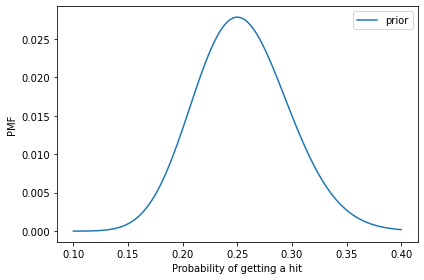

In [26]:
# Constructing a reasonable Prior
# uniform prior set from 100 - 400 batting average: Why did autho not set a 200 - 330?
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

# likelihoods
lk = {'Y': hypos,
      'N': 1 - hypos}

# data (random)
dataset = 'Y' * 25 + 'N' * 75

# update:
for data in dataset:
    prior *= lk[data]

prior.normalize()

prior.plot(label='prior')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF');

In [31]:
# let's also build a uniform prior given the 200 - 330 info:
hypos2 = np.linspace(0.2, 0.330, 101)
prior2 = Pmf(1, hypos2)

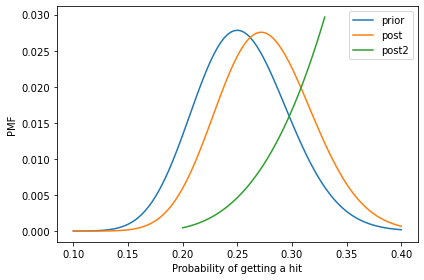

In [32]:
# update with our actual data:
dataset = 'YYY'
post = prior.copy()
post2 = prior2.copy()

for data in dataset:
    post *= lk[data]
    post2 *= lk[data]

post.normalize()
post2.normalize()

prior.plot(label='prior')
post.plot(label='post')
post2.plot(label='post2')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF');

In [35]:
# we can note the shift in max_prob from prior -> post
# makes sense given we have data showing all hits
# however, prior dist still playing a huge role
print(prior.max_prob())
print(post.max_prob())
print(post2.max_prob())

0.25
0.271
0.33


### Noticeable issue:

For this problem we see "1.00" batting average in data, so the second prior which is just uniform capped from 0.2 - 0.33 latches onto the most extreme value in the prior, which is 0.33. This makes for a very ugly posterior.

### Exercise 2:

Exercise: Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to adjust their answers to show themselves in the most positive light. One way to improve the accuracy of the results is randomized response.

As an example, suppose you want to know how many people cheat on their taxes. If you ask them directly, it is likely that some of the cheaters will lie. You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,

- If they get heads, they report YES.

- If they get tails, they honestly answer the question “Do you cheat on your taxes?”

If someone says YES, we don’t know whether they actually cheat on their taxes; they might have flipped heads. Knowing this, people might be more willing to answer honestly.

Suppose you survey 100 people this way and get 80 YESes and 20 NOs. Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes? What is the most likely quantity in the posterior distribution?

In [46]:
# we just assume any distribution of tax fraud is likely given no better starting point
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

# Let's asssume we think tax fraud is around 20-60% so we more heavily weight these "x" values
hypos2 = np.ones(101)
hypos2[20:60] = 10
prior2 = Pmf(hypos2, hypos)

If our actual fraction of cheaters is `0.4` then we'd expect the following for Yes:

- (0.5 * 0.4) = 0.2 of our True yes identify
- (0.5 * 1) = 0.5 of our total say yes
- Overall 0.7

Can convert yes to equation: $0.5 * (1 + x)$

Or no: $0.5 * (1 - x)$


In [47]:
# likelihoods
lk = {'Y': 0.5 * (1 + hypos),
    'N': 0.5 * (1-hypos)}

# data (random)
dataset = 'Y' * 80 + 'N' * 20

# update:
for data in dataset:
    prior *= lk[data]
    prior2 *= lk[data]

prior.normalize()
prior2.normalize()

2.0802577517019718e-20

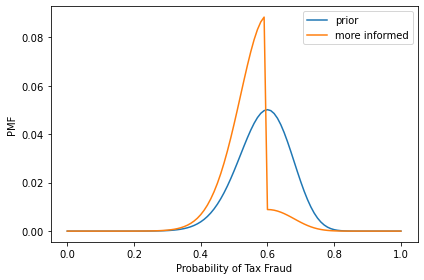

In [49]:
prior.plot(label='prior')
prior2.plot(label='more informed')
decorate(xlabel='Probability of Tax Fraud',
         ylabel='PMF');

In [50]:
print(prior.max_prob())
print(prior2.max_prob())

0.6
0.59


### Exercise 3: 


Suppose you want to test whether a coin is fair, but you don’t want to spin it hundreds of times. So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate. Specifically, suppose the probability is y=0.2 that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of x? What happens as you vary the value of y?

In [61]:
# I think our prior can still be uniform, although we could use the triangle prior here. 
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

# set y
y = 0.2

Likelihood:

Assume `x` is 0.4:

For heads:
- We would expect x * n heads, however we will falsely miss on `y` of these leaving us with: x * n * (1-y)
- We also will miss on some tails, which needs to be accounted for as these are flagged as `H`: (1-x) * n * (y)

For tails: 
- Similarly, we expect (1-x) * n tails, but will pickup what is missed from above: (1-x) * n + x * n * (y)
- We will also lose on some, at a rate of 1 - y, which can be added in

Can remove the `n` since we want for `n = 1` and write this as a likelihood for each flip:

- H: $x * (1 - y) + (1-x) * y$
- T: $(1-x) * (1-y) + x*y$

In [62]:
lk = {'H': hypos * (1-y) + (1-hypos) * y,
    'T': (1-hypos) * (1-y) + hypos * y}

In [63]:
# data 
dataset = 'H' * 140 + 'T' * 110

# update:
for data in dataset:
    prior *= lk[data]
    #prior2 *= lk[data]

prior.normalize()

4.391534169454059e-74

0.6


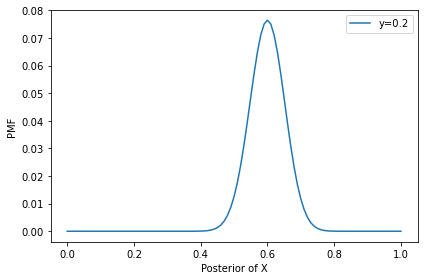

In [64]:
prior.plot(label='y=0.2')
#prior2.plot(label='more informed')
decorate(xlabel='Posterior of X',
         ylabel='PMF');

print(prior.max_prob())

In [69]:
# rewrite as a func
def likelihood(y):
    return {'H': hypos * (1-y) + (1-hypos) * y,
            'T': (1-hypos) * (1-y) + hypos * y}

# build a few
hypos = np.linspace(0, 1, 101)
prior0 = Pmf(1, hypos)
prior2 = Pmf(1, hypos)
prior4 = Pmf(1, hypos)

# build likelihoods
lk0 = likelihood(y = 0)
lk2 = likelihood(y = 0.2)
lk4 = likelihood(y = 0.4)

# data 
dataset = 'H' * 140 + 'T' * 110

# and update 
for data in dataset:
    prior0 *= lk0[data]
    prior2 *= lk2[data]
    prior4 *= lk4[data]
    
prior0.normalize()
prior2.normalize()
prior4.normalize()

1.196889105853248e-73

0.56
0.6
0.8


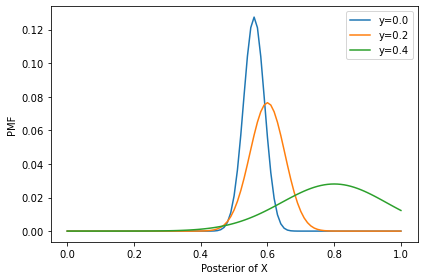

In [70]:
prior0.plot(label='y=0.0')
prior2.plot(label='y=0.2')
prior4.plot(label='y=0.4')
decorate(xlabel='Posterior of X',
         ylabel='PMF');

print(prior0.max_prob())
print(prior2.max_prob())
print(prior4.max_prob())

### Why Do We See Such Dramatic Shifts?

Plug into equation:

